In [23]:
import os
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision import models
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt

import cv2
import mediapipe as mp
import pyautogui

In [9]:
# ====== Настройки ======
print(f'Vesrsion of torch: {torch.__version__}')
data_dir = '../data/split'
batch_size = 128
epochs = 10
lr = 1e-3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Vesrsion of torch: 2.7.0+cu128


In [10]:
# ====== Аугментации и трансформации ======
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
# ====== Загрузка данных ======
train_dataset = ImageFolder(os.path.join('../data', 'sample_train'), transform=train_transform)
val_dataset   = ImageFolder(os.path.join(data_dir, 'val'), transform=val_test_transform)
test_dataset  = ImageFolder(os.path.join(data_dir, 'test'), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, num_workers=8)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,num_workers=8)


In [12]:
# --- Подготовка случайного поднабора из 500 примеров ---
num_val_samples = 500
all_indices = list(range(len(val_dataset)))
# если валидационный набор меньше 500, возьмём весь
selected_indices = random.sample(all_indices, min(num_val_samples, len(all_indices)))
# создаём Subset и новый DataLoader
val_subset = Subset(val_dataset, selected_indices)
val_subset_loader = DataLoader(
    val_subset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=val_loader.num_workers,
    pin_memory=True
)

## Обучаю свою простую CNN

In [26]:
# ====== Своя CNN ======
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  # (B, 3, 224, 224) -> (B, 32, 224, 224)
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> (B, 32, 112, 112)

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> (B, 64, 56, 56)

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),                # -> (B, 128, 28, 28)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        return self.fc(x)

model = SimpleCNN(num_classes=len(train_dataset.classes)).to(device)

In [27]:
# ====== Обучение ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader):.4f}")

Epoch 1/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.45it/s]


Epoch 1, Loss: 2.1406


Epoch 2/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.74it/s]


Epoch 2, Loss: 2.0117


Epoch 3/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.71it/s]


Epoch 3, Loss: 1.8450


Epoch 4/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.41it/s]


Epoch 4, Loss: 1.6887


Epoch 5/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.64it/s]


Epoch 5, Loss: 1.5480


Epoch 6/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.74it/s]


Epoch 6, Loss: 1.4285


Epoch 7/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.68it/s]


Epoch 7, Loss: 1.3389


Epoch 8/10: 100%|██████████| 1298/1298 [01:22<00:00, 15.73it/s]


Epoch 8, Loss: 1.2594


Epoch 9/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.33it/s]


Epoch 9, Loss: 1.1973


Epoch 10/10: 100%|██████████| 1298/1298 [01:24<00:00, 15.40it/s]

Epoch 10, Loss: 1.1238


In [28]:
# ====== Оценка ======
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))

# ====== Сохранение ======
torch.save(model.state_dict(), "custom_gesture_model.pth")


Classification Report:
              precision    recall  f1-score   support

     dislike       0.74      0.76      0.75      4745
        fist       0.55      0.61      0.58      4732
        like       0.57      0.62      0.60      4688
        mute       0.77      0.76      0.77      4853
  no_gesture       0.33      0.48      0.39       326
          ok       0.62      0.44      0.51      4674
         one       0.53      0.65      0.58      4782
        palm       0.67      0.64      0.66      4757
        stop       0.57      0.48      0.52      4691

    accuracy                           0.62     38248
   macro avg       0.60      0.61      0.60     38248
weighted avg       0.63      0.62      0.62     38248



## Обучаю resnet

In [13]:
# ====== Загрузка предобученной ResNet18 и изменение последнего слоя ======
resnet_model = models.resnet18(pretrained=True)

# Если хочешь дообучить все слои – не замораживай ничего.
# Для заморозки всех слоёв кроме последнего:
# for param in resnet_model.parameters():
#     param.requires_grad = False

num_classes = len(train_dataset.classes)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, num_classes)

resnet_model = resnet_model.to(device)

c:\Users\socol\Vs Code projects\YoutubeGestures\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\socol\Vs Code projects\YoutubeGestures\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# ====== Настройка обучения ======
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=lr)

In [15]:
# ====== Цикл обучения ======
train_losses = []
val_losses = []

for epoch in range(epochs):
    resnet_model.train()
    running_loss = 0.0

    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # --- Валидационная фаза ---
    resnet_model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_subset_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet_model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
    avg_val_loss = running_val_loss / len(val_subset_loader)
    val_losses.append(avg_val_loss)


    print(f"Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

Epoch 1/10: 100%|██████████| 325/325 [01:32<00:00,  3.53it/s]


Epoch 0/10 — Train Loss: 0.4863, Val Loss: 0.3741


Epoch 2/10: 100%|██████████| 325/325 [01:31<00:00,  3.56it/s]


Epoch 1/10 — Train Loss: 0.2564, Val Loss: 0.1928


Epoch 3/10: 100%|██████████| 325/325 [01:32<00:00,  3.52it/s]


Epoch 2/10 — Train Loss: 0.2106, Val Loss: 0.1406


Epoch 4/10: 100%|██████████| 325/325 [01:33<00:00,  3.48it/s]


Epoch 3/10 — Train Loss: 0.1762, Val Loss: 0.1805


Epoch 5/10: 100%|██████████| 325/325 [01:31<00:00,  3.56it/s]


Epoch 4/10 — Train Loss: 0.1613, Val Loss: 0.1542


Epoch 6/10: 100%|██████████| 325/325 [01:32<00:00,  3.52it/s]


Epoch 5/10 — Train Loss: 0.1449, Val Loss: 0.1336


Epoch 7/10: 100%|██████████| 325/325 [01:32<00:00,  3.50it/s]


Epoch 6/10 — Train Loss: 0.1331, Val Loss: 0.0865


Epoch 8/10: 100%|██████████| 325/325 [01:33<00:00,  3.49it/s]


Epoch 7/10 — Train Loss: 0.1217, Val Loss: 0.1274


Epoch 9/10: 100%|██████████| 325/325 [01:33<00:00,  3.49it/s]


Epoch 8/10 — Train Loss: 0.1144, Val Loss: 0.0923


Epoch 10/10: 100%|██████████| 325/325 [01:33<00:00,  3.49it/s]


Epoch 9/10 — Train Loss: 0.1098, Val Loss: 0.1081


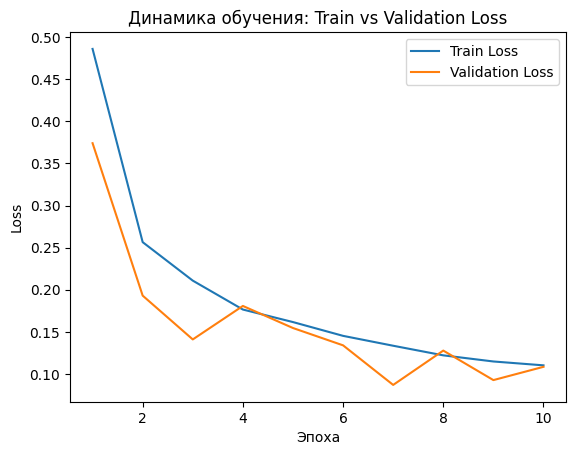

In [16]:
# --- Построение графика ---
plt.figure()
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses,   label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Динамика обучения: Train vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
# ====== Оценка ======
resnet_model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = resnet_model(images)
        preds = outputs.argmax(dim=1).cpu()
        y_pred.extend(preds.tolist())
        y_true.extend(labels.tolist())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_dataset.classes))


Classification Report:
              precision    recall  f1-score   support

     dislike       0.96      0.98      0.97      4745
        fist       0.98      0.89      0.94      4732
        like       0.94      0.95      0.94      4688
        mute       0.99      0.96      0.97      4853
  no_gesture       0.80      0.94      0.87       326
          ok       0.97      0.93      0.95      4674
         one       0.92      0.94      0.93      4782
        palm       0.91      0.98      0.94      4757
        stop       0.93      0.95      0.94      4691

    accuracy                           0.95     38248
   macro avg       0.93      0.95      0.94     38248
weighted avg       0.95      0.95      0.95     38248



In [19]:
#====== Сохранение ======
torch.save(resnet_model.state_dict(), "trained_res18.pth")

In [47]:
# ——— Настройка модели ———
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(weights=None)
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load('trained_res18.pth'))
model.to(device).eval()

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [70]:
# ——— Настройка MediaPipe ———
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.95,
    min_tracking_confidence=0.95
)
mp_draw = mp.solutions.drawing_utils

In [73]:
# thresholds
TH_X, TH_Y = 40, 40

cap = cv2.VideoCapture('test_video.mp4')
if not cap.isOpened():
    print("Ошибка: не удалось открыть видеофайл.")
tracking = False
start_pos = None
active_gesture = None

In [74]:
while True:
    ret, frame = cap.read()
    if not ret: break

    # 1) классификация
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(pil)
        cls = out.argmax(1).item()
    gesture = train_dataset.classes[cls]  # e.g. 'palm', 'one', etc.

    # 2) детекция ключевых точек руки
    res = hands.process(img)
    if res.multi_hand_landmarks:
        lm = res.multi_hand_landmarks[0].landmark
        coords = np.array([[int(pt.x*frame.shape[1]), int(pt.y*frame.shape[0])]
                           for pt in lm])
        center = coords.mean(axis=0).astype(int)  # (x, y)
        cv2.circle(frame, tuple(center), 5, (0,255,0), -1)
    else:
        center = None

    # 3) логика трекинга
    if gesture in ('palm','one') and center is not None:
        if not tracking or gesture != active_gesture:
            # старт нового трекинга
            tracking = True
            active_gesture = gesture
            start_pos = center.copy()
        else:
            # уже в режиме трекинга — считаем смещение
            dx, dy = center - start_pos
            if gesture == 'palm':
                if abs(dx) > TH_X:
                    if dx > 0: pyautogui.press('right')
                    else:      pyautogui.press('left')
                    start_pos = center  # обновляем базу
            if gesture == 'one':
                if abs(dy) > TH_Y:
                    if dy < 0: pyautogui.press('up')
                    else:      pyautogui.press('down')
                    start_pos = center
    else:
        tracking = False

    # отображение
    cv2.putText(frame, gesture, (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    cv2.imshow("Gestures", frame)
    if cv2.waitKey(1) == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()